# Neural Network from Scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generate some Data

In [2]:
N = 10000
upper = 3
lower = 0
x = np.linspace(lower, upper, N)
x = x.reshape(-1,1)

In [3]:
# y = (120*np.sin(x)+270*np.sin(x-35) + 50*np.sin(x))
y = np.sin(x)

/tmp/ipykernel_3149362/3873877298.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


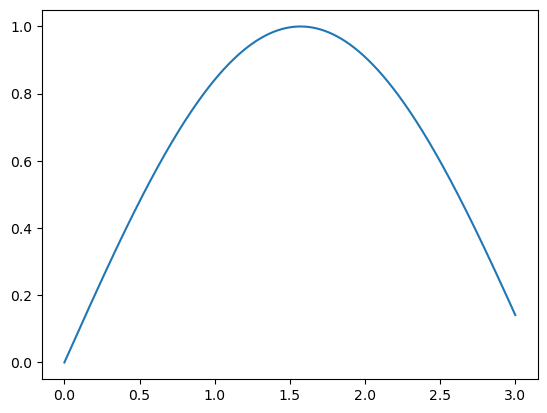

In [4]:
f = plt.figure()
plt.plot(x,y)
f.show()

## Define a Network

See p. 210 and 239 of Neural Networks from scratch.

In [5]:
class Dense:
    def __init__(self, inputs, neurons):
        self.weights = 0.1 * np.random.randn(inputs, neurons)
        self.weights = np.abs(self.weights)
        print(self.weights)
        self.biases = np.zeros((1, neurons))
    def forward(self,inputs):
        self.inputs = inputs # store the inputs to calculage gradient next time
        self.output=np.dot(inputs, self.weights) + self.biases
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues) # d/dw(w.x) = x^t Derivative of weights is inputs, multiply this by pre-existing derivative
        self.dbiases = np.sum(dvalues, axis=0, keepdims = True)
        
        # Gradient on values (d/dx)
        self.dinputs = np.dot(dvalues, self.weights.T) # d/dx(w.x) = w^t
        

In [6]:
class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        self.inputs = inputs # Store the inputs for backprop
        self.output = np.maximum(0, inputs)
        
    def backward(self, dvalues):
        # The original variable needs to be modified, so make a copy of it first
        self.dinputs = dvalues.copy()
        
        # Gradient is zero where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [7]:
# Common class for loss
class Loss:
    # Calculates the loss function given observations and prediction
    def calculate(self, output, y):
        
        # Calculate the losses for everything given
        sample_losses = self.forward(output, y)
        
        # Average it
        data_loss = np.mean(sample_losses)
        
        return data_loss

The dvalues will be the very last output of the final layer, then we will backward pass the dinputs to perform the backward pass, at each step the dinputs will calculate a dweights for the dense layer.

We need the dinputs for the backward pass to work and so we can calculate the dweights which is what we ultimately care about.

In [8]:
class Loss_SE(Loss):
    
    # Forward Pass
    # Leave Mean and Root to Parent class
    def forward(self, y_pred, y_true):
        return (y_pred-y_true)**2
        
    def backward(self, dvalues, y_pred, y_true):
        self.dinputs = 2*(y_pred-y_true)*dvalues
    

In [9]:
class Optimizer_SGD:
    # Initialize
    def __init__(self, learning_rate=1e-6):
        self.learning_rate = learning_rate
    # Update the parameters
    def update_params(self, layer):
        layer.weights -= self.learning_rate * layer.dweights
        layer.biases -= self.learning_rate * layer.dbiases
        
        

## Preview the Network

`#TODO` implement this as a function or a *raw* loop

In [10]:
class NN:
    def __init__(self, insize, h1, outsize, lr=1e-6):
        self.d1   = Dense(insize, h1)
        self.act1 = ReLU()
        self.d2   = Dense(h1, outsize)
        self.act2 = ReLU()
        self.l = Loss_SE()
        self.optimizer = Optimizer_SGD(lr)
    def forward(self, x):
        # TODO could this be more elegant?
        self.d1.forward(x)
        self.act1.forward(self.d1.output)
        self.d2.forward(self.act1.output)
        self.act2.forward(self.d2.output)
        return self.act2.output
    def loss(self, yhat, y):
        self.lossval = self.l.calculate(yhat, y)
        # This is the first backward, so the dvalues is just the lossval
        self.l.backward(self.lossval, yhat, y)   # The output is the derivative values for the loss
        return self.lossval
    def backward(self):
        # The first one is ∂ε/∂ŷ, so we need to pass dinputs around so we can get ∂ε/∂ŷ * ∂ŷ/∂act1
        # For the backward pass we pass along dinput d/dx, this is used as dvalues to calulate d/dw (dweights)
        self.act2.backward(self.l.dinputs)   # d/dw
        self.d2.backward(self.act2.dinputs)
        self.act1.backward(self.d2.dinputs)
        self.d1.backward(self.act1.dinputs)  
    def opt(self):
        self.optimizer.update_params(self.d1)
        self.optimizer.update_params(self.d1) # TODO This is wrong but it won't train without
        
    

In [11]:
net = NN(1, 20, 1, 0.1)
yhat = net.forward(x)

[[0.09474714 0.05420989 0.05040899 0.05949598 0.12187478 0.1679482
  0.06191638 0.12105228 0.03085991 0.10810699 0.00134593 0.07748239
  0.15935694 0.06531762 0.17908565 0.11194128 0.13699644 0.05875438
  0.18657222 0.10486437]]
[[0.07880849]
 [0.01690282]
 [0.11482055]
 [0.10477852]
 [0.07933169]
 [0.10663306]
 [0.07244113]
 [0.02670288]
 [0.05264512]
 [0.12212236]
 [0.14462613]
 [0.06992815]
 [0.12683809]
 [0.14019588]
 [0.03868395]
 [0.04659071]
 [0.10721823]
 [0.04574015]
 [0.08558292]
 [0.15213136]]


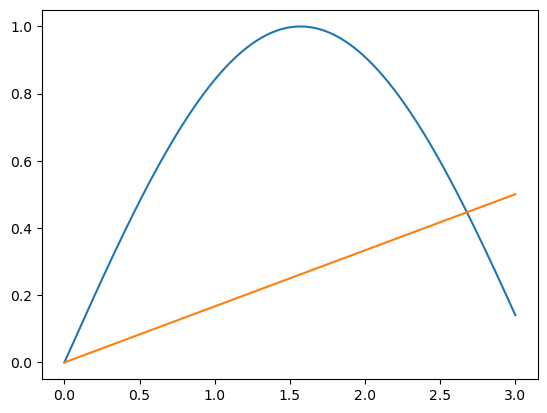

In [12]:
plt.plot(x, y)
plt.plot(x, yhat)

In [13]:
losses = []
for epoch in range(20):
    yhat = net.forward(x)
    losses.append(net.loss(yhat, y))
    net.backward()
    net.opt()
    print(losses)
    print(np.mean(net.d1.weights))
    print(np.mean(net.d2.weights))
# TODO remove post debug
if np.abs(np.mean(net.d1.weights)) > 1e16:
    print("Warning, the weights have gone to infinity")
    

[0.2606174486776585]
48.51367106557705
0.08663610818596625
[0.2606174486776585, 60391.64812013551]
-8797071605.454952
0.08663610818596625
[0.2606174486776585, 60391.64812013551, 0.5232332914316506]
-8797071605.454952
0.08663610818596625
[0.2606174486776585, 60391.64812013551, 0.5232332914316506, 0.5232332914316506]
-8797071605.454952
0.08663610818596625
[0.2606174486776585, 60391.64812013551, 0.5232332914316506, 0.5232332914316506, 0.5232332914316506]
-8797071605.454952
0.08663610818596625
[0.2606174486776585, 60391.64812013551, 0.5232332914316506, 0.5232332914316506, 0.5232332914316506, 0.5232332914316506]
-8797071605.454952
0.08663610818596625
[0.2606174486776585, 60391.64812013551, 0.5232332914316506, 0.5232332914316506, 0.5232332914316506, 0.5232332914316506, 0.5232332914316506]
-8797071605.454952
0.08663610818596625
[0.2606174486776585, 60391.64812013551, 0.5232332914316506, 0.5232332914316506, 0.5232332914316506, 0.5232332914316506, 0.5232332914316506, 0.5232332914316506]
-879707

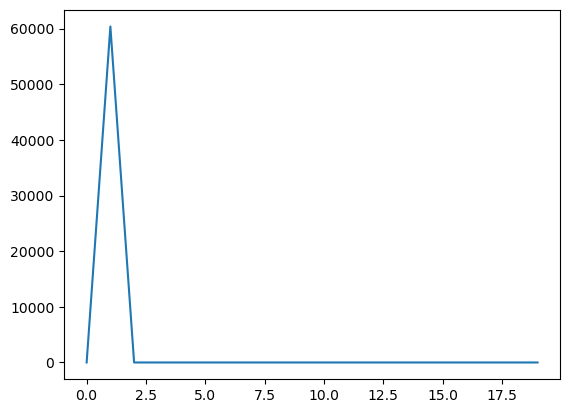

In [14]:
plt.plot(losses)

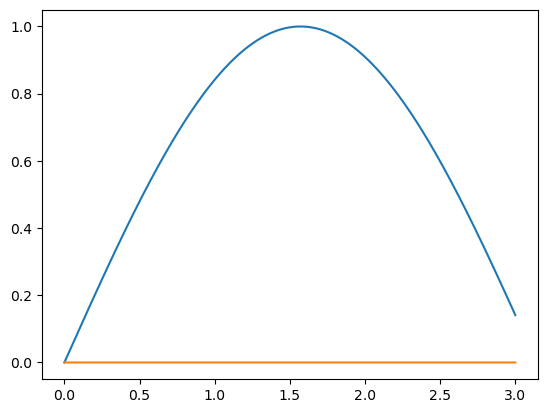

In [15]:
plt.plot(x, y)
plt.plot(x, yhat)